## Using Seurat to integrate multiple timepoints from the subsetted dataset

- Last updated: 2/2/2024

- Background: We wanted to re-compute the UMAPs for different anatomical subsets from the zebrahub object. 

In [5]:
library(data.table)
library(dplyr)
library(Seurat)
library(viridis)
library(ggExtra)
library(ggplot2)

library(SeuratData)
library(SeuratDisk)

In [3]:
ATLAS_DIR = '/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/'        # Read QC'd h5ad from here 
SCT_ATLAS = '/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/seurat_integrated_objects/' # Write integrated Atlas (after SCT pipeline) here
# ATLAS_FILE  = 'danio_atlas_RNB_annotated.rds'

"umap_CNS.h5ad", "CNS" was computed from the initial trial run, so we will remove "CNS" from the list, and re-run the following code cell.

In [4]:
setwd(ATLAS_DIR)

In [ ]:
# list of subsetted datasets and names
file.list <- c("umap_CNS.h5ad","umap_endoderm.h5ad","umap_hematopoetic.h5ad","umap_mesoderm.h5ad", "umap_periderm.h5ad")
subset.name.list <- c("CNS","endoderm","hematopoetic","mesoderm", "periderm")

for (index in 1:length(file.list)){
    # extract the filename
    file <- file.list[[index]]
    
    # convert the h5ad object to h5Seurat
    seurat_obj_path <- Convert(file, dest = "h5seurat", overwrite=TRUE)
    
    # read the h5Seurat format as a Seurat object
    seurat_file <- LoadH5Seurat(seurat_obj_path, assays="RNA")
    seurat_file
    
    # Integration 
    print(paste("Split object by timepoint"))
    # 1. Split object and process each time point independently 
    danio.list <- SplitObject(seurat_file, split.by='timepoint')
    
    # Filter out the timepoint where there are fewer than 10 cells
    # Create an empty list to store filtered Seurat objects
    filtered_danio_list <- list()

    # Loop through each Seurat object in danio.list
    for (timepoint in names(danio.list)) {
        # Check if the number of samples (cells) is 10 or more
        if (ncol(danio.list[[timepoint]]) >= 10) {
            # If yes, add the Seurat object to the filtered list
            filtered_danio_list[[timepoint]] <- danio.list[[timepoint]]
        }
    }
    
    danio.list <- filtered_danio_list
    
    # find variable features
    danio.list <- lapply(X = danio.list, FUN = function(x) {
        #x <- NormalizeData(x) # this dataset is already log-normalized
        x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
    })

    features <- SelectIntegrationFeatures(object.list = danio.list)

#     danio.list <- lapply(X = danio.list, FUN = function(x) {
#         x <- ScaleData(x, features = features, verbose = FALSE)
#         x <- RunPCA(x, features = features, verbose = FALSE)
#     })
    # Adjust the number of PCs based on the number of cells
    # Finding the smallest number of cells in the datasets
    min_cells <- min(sapply(danio.list, ncol))

    # Setting the maximum number of PCA components
    max_pca_dims <- min(min_cells - 1, 30)
    
    # Setting the k.score (FindIntegrationAnchors)
    k.score_value <- min(round(min_cells/2), 30)
    
    danio.list <- lapply(X = danio.list, FUN = function(x) {
        #num_cells <- ncol(x)
        #num_pcs <- min(num_cells - 1, 30)  # Adjusting the number of PCs
        x <- ScaleData(x, features = features, verbose = FALSE)
        x <- RunPCA(x, features = features, npcs = max_pca_dims, verbose = FALSE)
        return(x)
    })


    print(paste("Integration ... "))
    # 2. Find integration anchors and integrate data 
#     # Get the index for the "10hpf" entry
#     index_10hpf <- which(names(danio.list) == "10hpf")
#     index_10hpf

#     # Get the index for the "10dpf" entry
#     index_10dpf <- which(names(danio.list) == "10dpf")
#     index_10dpf
    danio.anchors <- FindIntegrationAnchors(object.list = danio.list, anchor.features = features,
                                           normalization.method = 'LogNormalize', #c("LogNormalize", "SCT"),
                                           dims = 1:max_pca_dims, # default 1:30
                                           k.anchor = 5, #default 5
                                           k.filter = 200, #default 200 for a query cell, If the anchor reference cell is found within the first k.filter (200) neighbors, then we retain this anchor.
                                           k.score = k.score_value, # default 30: For each reference anchor cell, we determine its k.score (30) nearest within-dataset neighbors and its k.score nearest neighbors in the query dataset
                                           reduction = "rpca", # default cca, rpca should be faster 
                                           #reference = c(index_10hpf,index_10dpf) # the 10hpf and 10dpf timepoints as "references" that other datasets will be anchored against
                                           )
    # Integreate the datasets using "anchors" computed above
    min_neighborhood = min(round(min_cells/2), 30)

    seurat_combined <- IntegrateData(anchorset = danio.anchors, 
                                    new.assay.name = "integrated",
                                    dims=1:max_pca_dims,
                                    k.weight = min_neighborhood)

    # 3. Generate an integrated embedding: run PCA on integrated (corrected) counts 
    # specify that we will perform downstream analysis on the corrected data note that the
    # original unmodified data still resides in the 'RNA' assay
    DefaultAssay(seurat_combined) <- "integrated"

    # Run the standard workflow for visualization and clustering
    seurat_combined <- ScaleData(seurat_combined, verbose = FALSE)
    seurat_combined <- RunPCA(seurat_combined, npcs = 100, verbose = FALSE)
    print(paste("Runnning UMAP on the integrated PCA embedding..."))
    
    # 4. UMAP on integrated embbedding 
    seurat_combined <- RunUMAP(seurat_combined, reduction = "pca", dims = 1:30,
                                 metric='euclidean',
                                 n.neighbors = 30,
                                 local.connectivity  =1, # 1 default
                                 repulsion.strength = 1, # 1 default
                             )
    seurat_combined <- FindNeighbors(seurat_combined, reduction = "pca", dims = 1:30)
    seurat_combined <- FindClusters(seurat_combined, resolution = 0.5)
    
    print(paste("plotting UMAP with different batch keys..."))
    # Check the integrated UMAP
    plot1 <- DimPlot(seurat_combined, dims = c(1, 2), group.by = "timepoint")
    plot2 <- DimPlot(seurat_combined, dims = c(1, 2), group.by = "fish")
    #plot3 <- DimPlot(seurat_combined, dims = c(1, 2), group.by = "leiden")
    plot1 + plot2 #+ plot3

    # 5. Export R object 
    # name of the output file
    subset_celltype <- subset.name.list[[index]]
    saveRDS(seurat_combined, file = paste0(SCT_ATLAS, subset_celltype, "_seurat_integrated.rds")) 
    print(paste("RDS object saved"))
}   



Warning message:
“Unknown file type: h5ad”
Warning message:
“'assay' not set, setting to 'RNA'”
Creating h5Seurat file for version 3.1.5.9900

Adding X as data

Adding X as counts

Adding meta.features from var

Adding X_umap as cell embeddings for umap

Adding layer counts as data in assay counts

Adding layer counts as counts in assay counts

Validating h5Seurat file

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Initializing RNA with data

Adding counts for RNA

Adding feature-level metadata for RNA

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata



[1] "Split object by timepoint"
[1] "Integration ... "


Scaling features for provided objects

Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 2981 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 1648 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 910 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 935 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 593 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 6299 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 3296 anchors

Projecting new data onto SVD

Projecting new da

In [64]:
# min_cells <- min(sapply(danio.list, ncol))

# # Setting the maximum number of PCA components
# max_pca_dims <- min(min_cells - 1, 30)

# danio.list <- lapply(X = danio.list, FUN = function(x) {
#     #num_cells <- ncol(x)
#     #num_pcs <- min(num_cells - 1, 30)  # Adjusting the number of PCs
#     x <- ScaleData(x, features = features, verbose = FALSE)
#     x <- RunPCA(x, features = features, npcs = max_pca_dims, verbose = FALSE)
#     return(x)
# })

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”


# convert RDS objects (Seurat objects) to h5ad objects

In [7]:
setwd("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/seurat_integrated_objects/")

In [8]:
#file.list <- c("umap_CNS.h5ad","umap_endoderm.h5ad","umap_hematopoetic.h5ad","umap_mesoderm.h5ad", "umap_periderm.h5ad")
subset.name.list <- c("CNS","endoderm","hematopoetic","mesoderm", "periderm")

for (index in 1:length(subset.name.list)){
    # extract the filename
    celltype <- subset.name.list[[index]]
    
    # import the Seurat object
    seurat <- readRDS(paste0(celltype, "_seurat_integrated.rds"))
    
    # save as h5Seurat object
    SaveH5Seurat(seurat, filename = paste0(celltype, "_seurat_integrated.h5Seurat"))
    
    # Convert to a h5ad format
    Convert(paste0(celltype, "_seurat_integrated.h5Seurat"), dest="h5ad")
}

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding scale.data from integrated as X

Adding data from integrated as raw

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

Adding integrated_snn as neighbors

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding dat

Summary: The h5Seurat object contains "log-normalized" counts in the "counts' and "data" slots.

## update on 2/27/2024

- re-subsetted the Endoderm into "Endoderm" and "Neural_crest" as these two celltypes seem to be very distinct.



In [3]:
ATLAS_DIR = '/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/merlin_resubsetted_Jan2024/'        # Read QC'd h5ad from here 
SCT_ATLAS = '/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/seurat_integrated_objects/' # Write integrated Atlas (after SCT pipeline) here

"umap_CNS.h5ad", "CNS" was computed from the initial trial run, so we will remove "CNS" from the list, and re-run the following code cell.

In [4]:
setwd(ATLAS_DIR)

In [58]:
# read the count matrix and also the metadata
endoderm.counts <- ReadMtx("endoderm_sparse_matrix.mtx",
                           cells="endoderm_barcodes.tsv",
                           features="endoderm_features.tsv")
endoderm.meta.data <- read.csv("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/merlin_resubsetted_Jan2024/endoderm_obs.csv",
                               header=T)

rownames(endoderm.meta.data) = colnames(endoderm.counts)


In [59]:
# endoderm.meta.data <- read.csv("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/merlin_resubsetted_Jan2024/endoderm_obs.csv",
#                                header=T)
endoderm.meta.data %>% head

,X,zebrafish_anatomy_ontology_id,zebrafish_anatomy_ontology_class,fish,developmental_stage,timepoint,timepoint_cluster
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
TDR71_AGACTCAAGGCTAAAT-1,TDR71_AGACTCAAGGCTAAAT-1,ZFA:0000017,endoderm,TDR71,larval-10dpf,10dpf,38
TDR74_TGTGTGAAGTGCCAGA-1,TDR74_TGTGTGAAGTGCCAGA-1,ZFA:0000017,endoderm,TDR74,larval-10dpf,10dpf,20
TDR70_TCTAACTGTTTGAAAG-1,TDR70_TCTAACTGTTTGAAAG-1,ZFA:0000017,endoderm,TDR70,larval-3dpf,3dpf,34
TDR73_CACAGATTCTTACGTT-1,TDR73_CACAGATTCTTACGTT-1,ZFA:0000017,endoderm,TDR73,larval-10dpf,10dpf,19
TDR73_AAGCATCCACACACGC-1,TDR73_AAGCATCCACACACGC-1,ZFA:0000017,endoderm,TDR73,larval-10dpf,10dpf,20
TDR73_CAGTTCCTCGGTCGAC-1,TDR73_CAGTTCCTCGGTCGAC-1,ZFA:0000017,endoderm,TDR73,larval-10dpf,10dpf,20


In [60]:
# create a Seurat object
endoderm = CreateSeuratObject(counts = endoderm.counts, meta.data = endoderm.meta.data)
endoderm

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
27435 features across 2226 samples within 1 assay 
Active assay: RNA (27435 features, 0 variable features)

In [61]:
endoderm@meta.data %>% head

,orig.ident,nCount_RNA,nFeature_RNA,X,zebrafish_anatomy_ontology_id,zebrafish_anatomy_ontology_class,fish,developmental_stage,timepoint,timepoint_cluster
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
TDR71_AGACTCAAGGCTAAAT-1,TDR71,7581,1073,TDR71_AGACTCAAGGCTAAAT-1,ZFA:0000017,endoderm,TDR71,larval-10dpf,10dpf,38
TDR74_TGTGTGAAGTGCCAGA-1,TDR74,12621,2027,TDR74_TGTGTGAAGTGCCAGA-1,ZFA:0000017,endoderm,TDR74,larval-10dpf,10dpf,20
TDR70_TCTAACTGTTTGAAAG-1,TDR70,6122,1313,TDR70_TCTAACTGTTTGAAAG-1,ZFA:0000017,endoderm,TDR70,larval-3dpf,3dpf,34
TDR73_CACAGATTCTTACGTT-1,TDR73,2822,934,TDR73_CACAGATTCTTACGTT-1,ZFA:0000017,endoderm,TDR73,larval-10dpf,10dpf,19
TDR73_AAGCATCCACACACGC-1,TDR73,2987,834,TDR73_AAGCATCCACACACGC-1,ZFA:0000017,endoderm,TDR73,larval-10dpf,10dpf,20
TDR73_CAGTTCCTCGGTCGAC-1,TDR73,3196,837,TDR73_CAGTTCCTCGGTCGAC-1,ZFA:0000017,endoderm,TDR73,larval-10dpf,10dpf,20


In [62]:
# save the Seurat object
saveRDS(endoderm, file = "/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/merlin_resubsetted_Jan2024/umap_endodermV3.rds")

In [6]:
endoderm <- readRDS("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/merlin_resubsetted_Jan2024/umap_endodermV3.rds")
endoderm

An object of class Seurat 
27435 features across 2226 samples within 1 assay 
Active assay: RNA (27435 features, 0 variable features)

### neural_crest Seurat object

In [79]:
# read the count matrix and also the metadata
neural_crest.counts <- ReadMtx("neural_crest_sparse_matrix.mtx",
                           cells="neural_crest_barcodes.tsv",
                           features="neural_crest_features.tsv")
neural_crest.meta.data <- read.csv("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/merlin_resubsetted_Jan2024/neural_crest_obs.csv",
                               header=T)
# set the rownames in the metadata
rownames(neural_crest.meta.data) = colnames(neural_crest.counts)

In [64]:
neural_crest = CreateSeuratObject(counts = neural_crest.counts, meta.data = neural_crest.meta.data)
neural_crest

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
27435 features across 2185 samples within 1 assay 
Active assay: RNA (27435 features, 0 variable features)

In [65]:
neural_crest@meta.data %>% head

,orig.ident,nCount_RNA,nFeature_RNA,X,zebrafish_anatomy_ontology_id,zebrafish_anatomy_ontology_class,fish,developmental_stage,timepoint,timepoint_cluster
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
TDR70_ACGTAACCAACTGATC-1,TDR70,5203,1466,TDR70_ACGTAACCAACTGATC-1,ZFA:0000045,neural_crest,TDR70,larval-3dpf,3dpf,35
TDR46_GTTCATTGTTTGAAAG-1,TDR46,20816,3820,TDR46_GTTCATTGTTTGAAAG-1,ZFA:0000045,neural_crest,TDR46,30 somites,24hpf,28
TDR48_GTCTACCTCCTCTCGA-1,TDR48,2157,811,TDR48_GTCTACCTCCTCTCGA-1,ZFA:0000045,neural_crest,TDR48,larval-2dpf,2dpf,26
TDR52_CACTGGGAGCGTTAGG-1,TDR52,3647,1282,TDR52_CACTGGGAGCGTTAGG-1,ZFA:0000045,neural_crest,TDR52,larval-5dpf,5dpf,25
TDR67_TAGCACAAGGTACATA-1,TDR67,5700,1689,TDR67_TAGCACAAGGTACATA-1,ZFA:0000045,neural_crest,TDR67,larval-3dpf,3dpf,35
TDR47_TGCATGATCAGAACCT-1,TDR47,7913,2109,TDR47_TGCATGATCAGAACCT-1,ZFA:0000045,neural_crest,TDR47,larval-2dpf,2dpf,20


In [66]:
# save the Seurat object
saveRDS(neural_crest, file = "/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/merlin_resubsetted_Jan2024/umap_neuralcrestV3.rds")

In [7]:
neural_crest <- readRDS("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/merlin_resubsetted_Jan2024/umap_neuralcrestV3.rds")
neural_crest

An object of class Seurat 
27435 features across 2185 samples within 1 assay 
Active assay: RNA (27435 features, 0 variable features)

In [8]:
# create a list of seurat objects
seurat.obj.list <- list(endoderm, neural_crest)
seurat.obj.list

[[1]]
An object of class Seurat 
27435 features across 2226 samples within 1 assay 
Active assay: RNA (27435 features, 0 variable features)

[[2]]
An object of class Seurat 
27435 features across 2185 samples within 1 assay 
Active assay: RNA (27435 features, 0 variable features)


In [9]:
for (index in 1:length(seurat.obj.list)){
    # extract the Seurat object
    seurat_file <- seurat.obj.list[[index]]
    print(seurat_file)}

An object of class Seurat 
27435 features across 2226 samples within 1 assay 
Active assay: RNA (27435 features, 0 variable features)
An object of class Seurat 
27435 features across 2185 samples within 1 assay 
Active assay: RNA (27435 features, 0 variable features)


In [10]:
# list of subsetted datasets and names
# file.list <- c("umap_endodermV3.h5ad","umap_neuralcrestV3.h5ad")
seurat.obj.list <- list(endoderm, neural_crest)
subset.name.list <- c("endoderm", "neuralcrest")

for (index in 1:length(seurat.obj.list)){
    # extract the Seurat object
    seurat_file <- seurat.obj.list[[index]]
    
    # Integration 
    print(paste("Split object by timepoint"))
    # 1. Split object and process each time point independently 
    danio.list <- SplitObject(seurat_file, split.by='timepoint')
    
    # Filter out the timepoint where there are fewer than 10 cells
    # Create an empty list to store filtered Seurat objects
    filtered_danio_list <- list()

    # Loop through each Seurat object in danio.list
    for (timepoint in names(danio.list)) {
        # Check if the number of samples (cells) is 15 or more
        if (ncol(danio.list[[timepoint]]) >= 15) {
            # If yes, add the Seurat object to the filtered list
            filtered_danio_list[[timepoint]] <- danio.list[[timepoint]]
        }
    }
    
    danio.list <- filtered_danio_list
    
    # find variable features
    danio.list <- lapply(X = danio.list, FUN = function(x) {
        #x <- NormalizeData(x) # this dataset is already log-normalized
        x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
    })

    features <- SelectIntegrationFeatures(object.list = danio.list)

#     danio.list <- lapply(X = danio.list, FUN = function(x) {
#         x <- ScaleData(x, features = features, verbose = FALSE)
#         x <- RunPCA(x, features = features, verbose = FALSE)
#     })
    # Adjust the number of PCs based on the number of cells
    # Finding the smallest number of cells in the datasets
    min_cells <- min(sapply(danio.list, ncol))

    # Setting the maximum number of PCA components
    max_pca_dims <- min(min_cells - 1, 30)
    
    # Setting the k.score (FindIntegrationAnchors)
    k.score_value <- min(round(min_cells/2), 30)
    
    danio.list <- lapply(X = danio.list, FUN = function(x) {
        #num_cells <- ncol(x)
        #num_pcs <- min(num_cells - 1, 30)  # Adjusting the number of PCs
        x <- ScaleData(x, features = features, verbose = FALSE)
        x <- RunPCA(x, features = features, npcs = max_pca_dims, verbose = FALSE)
        return(x)
    })


    print(paste("Integration ... "))
    # 2. Find integration anchors and integrate data 
#     # Get the index for the "10hpf" entry
#     index_10hpf <- which(names(danio.list) == "10hpf")
#     index_10hpf

#     # Get the index for the "10dpf" entry
#     index_10dpf <- which(names(danio.list) == "10dpf")
#     index_10dpf
    danio.anchors <- FindIntegrationAnchors(object.list = danio.list, anchor.features = features,
                                           normalization.method = 'LogNormalize', #c("LogNormalize", "SCT"),
                                           dims = 1:max_pca_dims, # default 1:30
                                           k.anchor = 5, #default 5
                                           k.filter = 200, #default 200 for a query cell, If the anchor reference cell is found within the first k.filter (200) neighbors, then we retain this anchor.
                                           k.score = k.score_value, # default 30: For each reference anchor cell, we determine its k.score (30) nearest within-dataset neighbors and its k.score nearest neighbors in the query dataset
                                           reduction = "rpca", # default cca, rpca should be faster 
                                           #reference = c(index_10hpf,index_10dpf) # the 10hpf and 10dpf timepoints as "references" that other datasets will be anchored against
                                           )
    # Integreate the datasets using "anchors" computed above
    min_neighborhood = min(round(min_cells/2), 30)

    seurat_combined <- IntegrateData(anchorset = danio.anchors, 
                                    new.assay.name = "integrated",
                                    dims=1:max_pca_dims,
                                    k.weight = min_neighborhood)

    # 3. Generate an integrated embedding: run PCA on integrated (corrected) counts 
    # specify that we will perform downstream analysis on the corrected data note that the
    # original unmodified data still resides in the 'RNA' assay
    DefaultAssay(seurat_combined) <- "integrated"

    # Run the standard workflow for visualization and clustering
    seurat_combined <- ScaleData(seurat_combined, verbose = FALSE)
    seurat_combined <- RunPCA(seurat_combined, npcs = 100, verbose = FALSE)
    print(paste("Runnning UMAP on the integrated PCA embedding..."))
    
    # 4. UMAP on integrated embbedding 
    seurat_combined <- RunUMAP(seurat_combined, reduction = "pca", dims = 1:30,
                                 metric='euclidean',
                                 n.neighbors = 30,
                                 local.connectivity  =1, # 1 default
                                 repulsion.strength = 1, # 1 default
                             )
    seurat_combined <- FindNeighbors(seurat_combined, reduction = "pca", dims = 1:30)
    seurat_combined <- FindClusters(seurat_combined, resolution = 0.5)
    
    print(paste("plotting UMAP with different batch keys..."))
    # Check the integrated UMAP
    plot1 <- DimPlot(seurat_combined, dims = c(1, 2), group.by = "timepoint")
    plot2 <- DimPlot(seurat_combined, dims = c(1, 2), group.by = "fish")
    #plot3 <- DimPlot(seurat_combined, dims = c(1, 2), group.by = "leiden")
    plot1 + plot2 #+ plot3

    # 5. Export R object 
    # name of the output file
    subset_celltype <- subset.name.list[[index]]
    saveRDS(seurat_combined, file = paste0(SCT_ATLAS, subset_celltype, "_seurat_integrated.rds")) 
    print(paste("RDS object saved"))
}


[1] "Split object by timepoint"


Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.1224”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.49919”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.6298e-15”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -1.4522”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.49795”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  3.2061e-16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other 

[1] "Integration ... "


Scaling features for provided objects

Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 555 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 610 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 468 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 119 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 163 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 153 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 127 anchors

Projecting new data onto SVD

Projecting new data o

[1] "Runnning UMAP on the integrated PCA embedding..."


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
01:36:17 UMAP embedding parameters a = 0.9922 b = 1.112

01:36:17 Read 2215 rows and found 30 numeric columns

01:36:17 Using FNN for neighbor search, n_neighbors = 30

01:36:18 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

01:36:19 Initializing from normalized Laplacian + noise (using irlba)

01:36:19 Commencing optimization for 500 epochs, with 96042 positive edges

01:36:26 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2215
Number of edges: 71913

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8844
Number of communities: 12
Elapsed time: 0 seconds
[1] "plotting UMAP with different batch keys..."
[1] "RDS object saved"
[1] "Split object by timepoint"


Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -1.9956”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  8.2716e-16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.2227”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.6313e-15”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -1.5855”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning me

[1] "Integration ... "


Scaling features for provided objects

Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 169 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 307 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 414 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 422 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 305 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 572 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 323 anchors

Projecting new data onto SVD

Projecting new data o

[1] "Runnning UMAP on the integrated PCA embedding..."


01:37:40 UMAP embedding parameters a = 0.9922 b = 1.112

01:37:40 Read 2177 rows and found 30 numeric columns

01:37:40 Using FNN for neighbor search, n_neighbors = 30

01:37:41 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

01:37:42 Initializing from normalized Laplacian + noise (using irlba)

01:37:42 Commencing optimization for 500 epochs, with 93222 positive edges

01:37:50 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2177
Number of edges: 72439

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8933
Number of communities: 13
Elapsed time: 0 seconds
[1] "plotting UMAP with different batch keys..."
[1] "RDS object saved"


In [11]:
subset_celltype

[1] "neuralcrest"

In [64]:
# min_cells <- min(sapply(danio.list, ncol))

# # Setting the maximum number of PCA components
# max_pca_dims <- min(min_cells - 1, 30)

# danio.list <- lapply(X = danio.list, FUN = function(x) {
#     #num_cells <- ncol(x)
#     #num_pcs <- min(num_cells - 1, 30)  # Adjusting the number of PCs
#     x <- ScaleData(x, features = features, verbose = FALSE)
#     x <- RunPCA(x, features = features, npcs = max_pca_dims, verbose = FALSE)
#     return(x)
# })

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”


# convert RDS objects (Seurat objects) to h5ad objects

In [12]:
setwd("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/seurat_integrated_objects/")

In [13]:
#file.list <- c("umap_CNS.h5ad","umap_endoderm.h5ad","umap_hematopoetic.h5ad","umap_mesoderm.h5ad", "umap_periderm.h5ad")
subset.name.list <- c("endoderm","neuralcrest")

for (index in 1:length(subset.name.list)){
    # extract the filename
    celltype <- subset.name.list[[index]]
    
    # import the Seurat object
    seurat <- readRDS(paste0(celltype, "_seurat_integrated.rds"))
    
    # save as h5Seurat object
    SaveH5Seurat(seurat, filename = paste0(celltype, "_seurat_integrated.h5Seurat"))
    
    # Convert to a h5ad format
    Convert(paste0(celltype, "_seurat_integrated.h5Seurat"), dest="h5ad")
}

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding scale.data from integrated as X

Adding data from integrated as raw

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

Adding integrated_snn as neighbors

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding dat

In [15]:
endoderm@meta.data %>% head

,orig.ident,nCount_RNA,nFeature_RNA,X,zebrafish_anatomy_ontology_id,zebrafish_anatomy_ontology_class,fish,developmental_stage,timepoint,timepoint_cluster
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
TDR71_AGACTCAAGGCTAAAT-1,TDR71,7581,1073,TDR71_AGACTCAAGGCTAAAT-1,ZFA:0000017,endoderm,TDR71,larval-10dpf,10dpf,38
TDR74_TGTGTGAAGTGCCAGA-1,TDR74,12621,2027,TDR74_TGTGTGAAGTGCCAGA-1,ZFA:0000017,endoderm,TDR74,larval-10dpf,10dpf,20
TDR70_TCTAACTGTTTGAAAG-1,TDR70,6122,1313,TDR70_TCTAACTGTTTGAAAG-1,ZFA:0000017,endoderm,TDR70,larval-3dpf,3dpf,34
TDR73_CACAGATTCTTACGTT-1,TDR73,2822,934,TDR73_CACAGATTCTTACGTT-1,ZFA:0000017,endoderm,TDR73,larval-10dpf,10dpf,19
TDR73_AAGCATCCACACACGC-1,TDR73,2987,834,TDR73_AAGCATCCACACACGC-1,ZFA:0000017,endoderm,TDR73,larval-10dpf,10dpf,20
TDR73_CAGTTCCTCGGTCGAC-1,TDR73,3196,837,TDR73_CAGTTCCTCGGTCGAC-1,ZFA:0000017,endoderm,TDR73,larval-10dpf,10dpf,20


In [19]:
endoderm_integrated <- readRDS("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/seurat_integrated_objects/endoderm_seurat_integrated.rds")
endoderm_integrated

An object of class Seurat 
29435 features across 2215 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [20]:
neuralcrest_integrated <- readRDS("/hpc/projects/zebrahub/zebrahub_revision/scRNAseq/subset_lineages/seurat_integrated_objects/neuralcrest_seurat_integrated.rds")
neuralcrest_integrated

An object of class Seurat 
29435 features across 2177 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

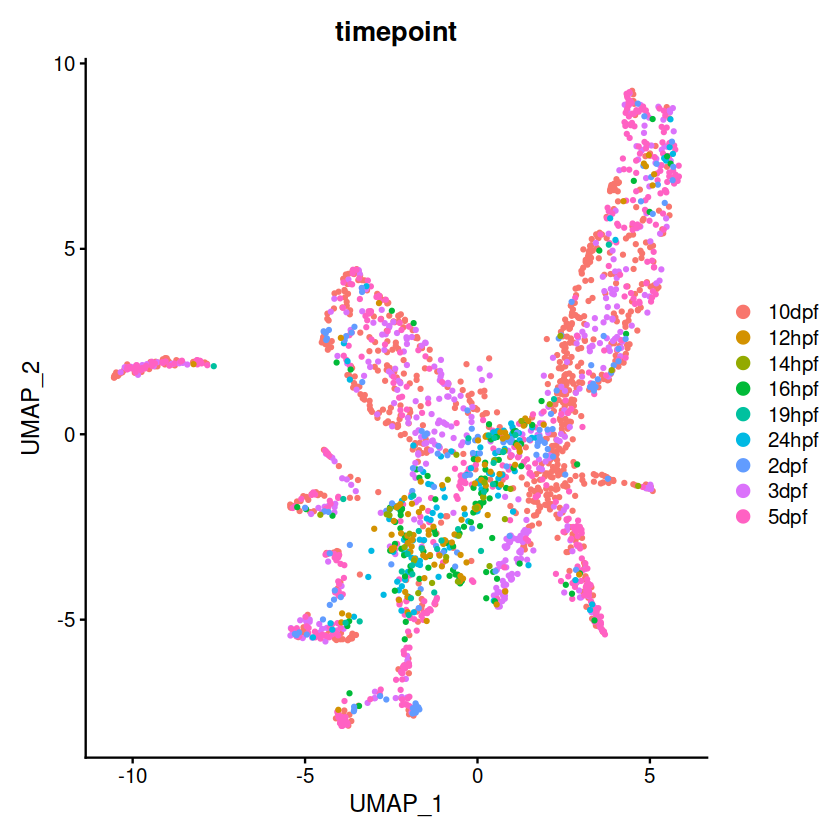

In [21]:
DimPlot(endoderm_integrated, dims = c(1,2), group.by="timepoint")

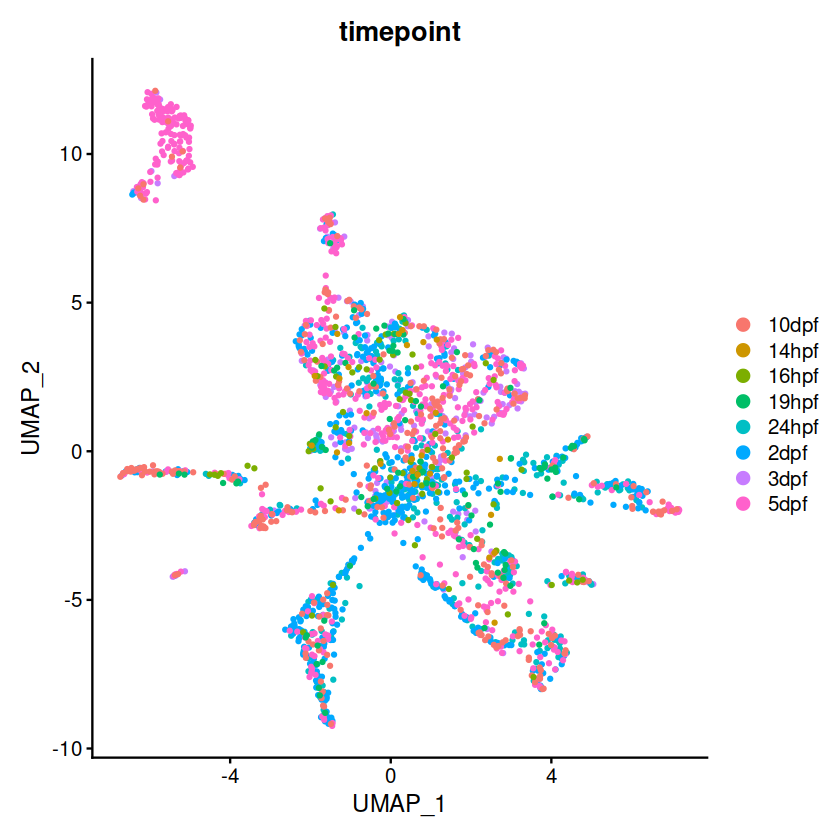

In [22]:
DimPlot(neuralcrest_integrated, dims = c(1,2), group.by="timepoint")